Rolling mean evaluation and basic forecast - ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src import prepare_europe_data, prepare_empty_frame, plot_covid_data
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import itertools

In [2]:
data_path = '../../data/raw/time_series_covid19_confirmed_global.csv'
data_raw = pd.read_csv(data_path)

In [3]:
data_prepared_poland = prepare_europe_data(data=data_raw, start_date='4/1/20', end_date='5/6/20', country='Poland')

In [4]:
data_prepared_poland.shape

(1, 37)

In [5]:
plot_covid_data(data=data_prepared_poland, country='Poland')

In [6]:
df = data_prepared_poland
df = df.T
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df = df.rename({'Poland': 'PolandConfirmedCases'}, axis=1)

In [7]:
df

Country/Region,PolandConfirmedCases
4/1/20,2554
4/2/20,2946
4/3/20,3383
4/4/20,3627
4/5/20,4102
4/6/20,4413
4/7/20,4848
4/8/20,5205
4/9/20,5575
4/10/20,5955


In [8]:
df_rolling_mean = df.rolling(window=4,center=False).mean().dropna()

In [9]:
df_rolling_mean

Country/Region,PolandConfirmedCases
4/4/20,3127.50
4/5/20,3514.50
4/6/20,3881.25
4/7/20,4247.50
4/8/20,4642.00
4/9/20,5010.25
4/10/20,5395.75
4/11/20,5772.75
4/12/20,6140.00
4/13/20,6479.75


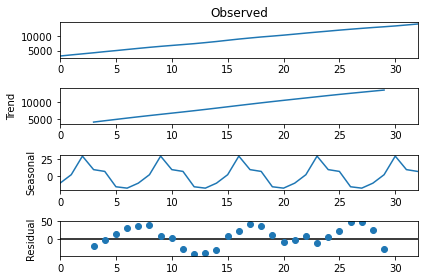

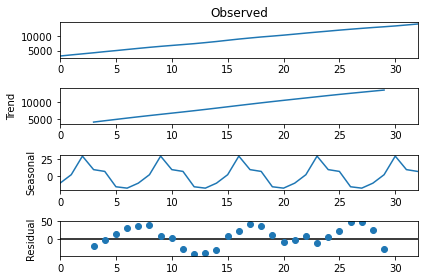

In [10]:
seasonal_decompose(df_rolling_mean.values,freq=7).plot()

In [11]:


def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

stationarity(df_rolling_mean.values)

Results of Dickey-Fuller Test:
Test Statistic                 -2.426189
p-value                         0.134481
#Lags Used                      3.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


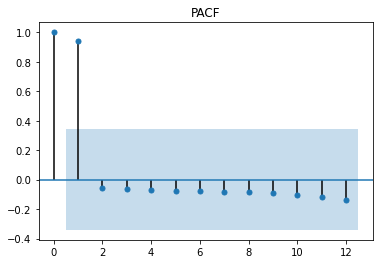

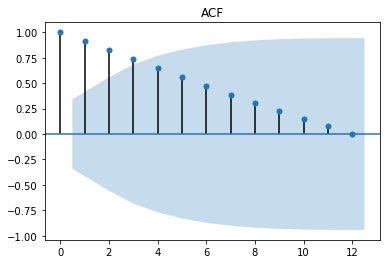

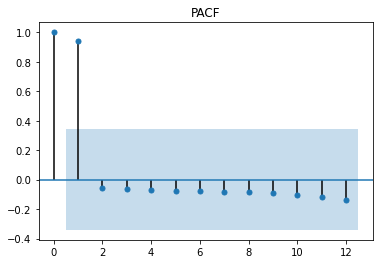

In [12]:
plot_acf(df_rolling_mean.values,lags=12,title="ACF")
plot_pacf(df_rolling_mean.values,lags=12,title="PACF")

In [13]:
X = df_rolling_mean.values
size = int(len(X) * 0.85)
train, test = X[0:size], X[size:len(X)]

In [14]:
def prepare_arima_param():
    params = {'p':[], 'd':[], 'q':[]}
    for key in params.keys():
        params[key] = range(0,6)
    pdq_product=list(itertools.product(params['p'], params['d'], params['q']))
    return pdq_product

def evaluate_arima_param(data):
    final_param = None
    current_best_result = float('Inf')
    pdq_product = prepare_arima_param()

    for param_set in pdq_product:

        try:
            model = ARIMA(data, order=param_set)
            result = model.fit()

            if (result.aic <= current_best_result):
                current_best_result = result.aic
                final_param = param_set
        except:
            continue
    print("Final params set: {}, Best result: {}".format(final_param, current_best_result))
    return final_param


In [15]:
final_param_set = evaluate_arima_param(train)

/Users/Filip/miniconda3/envs/ds_env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/Filip/miniconda3/envs/ds_env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Filip/miniconda3/envs/ds_env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/Filip/miniconda3/envs/ds_env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Filip/miniconda3/envs/ds_env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/Filip/miniconda3/envs/ds_env/lib/python3.6/site-packages/statsmodels/base/model.py

In [16]:
def predict_arima(train, test, param_order):
    model = ARIMA(train, order=param_order)
    result = model.fit()
    result.plot_predict(start=int(len(train) * 0.7), end=int(len(train) * 1.2))
    pred = result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax = plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())
    print(pred)
    return pred

/Users/Filip/miniconda3/envs/ds_env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   26
Model:                 ARIMA(4, 2, 2)   Log Likelihood                -112.754
Method:                       css-mle   S.D. of innovations             16.201
Date:                Tue, 29 Sep 2020   AIC                            241.508
Time:                        23:01:07   BIC                            251.573
Sample:                             2   HQIC                           244.406
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8577      0.68

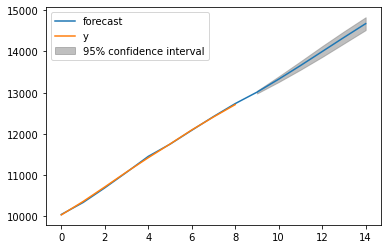

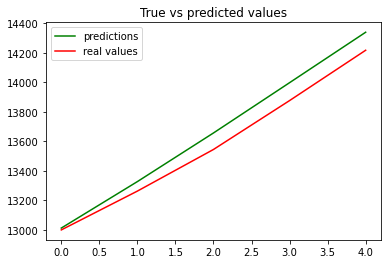

In [17]:
prediction = predict_arima(train, test, final_param_set)

In [18]:
prediction

array([13011.71905319, 13326.90875499, 13656.6446245 , 13997.59024011,
       14339.62257605])

In [19]:
data_prepared_poland.values

array([['Poland', 2554, 2946, 3383, 3627, 4102, 4413, 4848, 5205, 5575,
        5955, 6356, 6674, 6934, 7202, 7582, 7918, 8379, 8742, 9287, 9593,
        9856, 10169, 10511, 10892, 11273, 11617, 11902, 12218, 12640,
        12877, 13105, 13375, 13693, 14006, 14431, 14740]], dtype=object)

In [20]:
def predict_arima_week_ahead(train, param_order):
    model = ARIMA(train, order=param_order)
    result = model.fit()
    pred = result.forecast(steps=7)[0]
    print(result.summary())
    print(pred)
    return pred

In [21]:
train_pl = data_prepared_poland.values

In [22]:
train_pl = train_pl[:,1:].reshape((36,1))

In [25]:
prediction_week_ahead = predict_arima_week_ahead(train_pl, final_param_set)

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   34
Model:                 ARIMA(4, 2, 2)   Log Likelihood                -191.618
Method:                       css-mle   S.D. of innovations             58.903
Date:                Tue, 29 Sep 2020   AIC                            399.235
Time:                        23:02:21   BIC                            411.446
Sample:                             2   HQIC                           403.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1775      0.446     -4.886      0.000      -3.051      -1.304
ar.L1.D2.y     0.7157      0.225      3.176      0.001       0.274       1.157
ar.L2.D2.y     0.1438      0.193      0.744      0.4

In [48]:
df_5_13_20 = prepare_empty_frame(start_date='5/7/20', end_date='5/13/20', country='Poland')

In [49]:
df_5_13_20

,Country/Region,5/7/2020,5/8/2020,5/9/2020,5/10/2020,5/11/2020,5/12/2020,5/13/2020
34,Poland,0,0,0,0,0,0,0


In [50]:
index = 0
for date in df_5_13_20.columns[1:]:
    print(date, prediction_week_ahead[index])
    df_5_13_20[date] = prediction_week_ahead[index]
    index += 1

5/7/2020 15090.531706054297
5/8/2020 15389.60149947839
5/9/2020 15713.670860105532
5/10/2020 16019.537602623312
5/11/2020 16339.426366248525
5/12/2020 16650.870458711794
5/13/2020 16966.9707660825


In [70]:
data_prepared_poland.keys()

Index(['Country/Region', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20',
       '4/6/20', '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20',
       '4/13/20', '4/14/20', '4/15/20', '4/16/20', '4/17/20', '4/18/20',
       '4/19/20', '4/20/20', '4/21/20', '4/22/20', '4/23/20', '4/24/20',
       '4/25/20', '4/26/20', '4/27/20', '4/28/20', '4/29/20', '4/30/20',
       '5/1/20', '5/2/20', '5/3/20', '5/4/20', '5/5/20', '5/6/20'],
      dtype='object')

In [73]:
df_5_13_20 = df_5_13_20.drop(columns='Country/Region')

In [76]:
df_5_13_20.keys()

Index(['5/7/2020', '5/8/2020', '5/9/2020', '5/10/2020', '5/11/2020',
       '5/12/2020', '5/13/2020'],
      dtype='object')

In [84]:
data_prepared_poland

,Country/Region,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,...,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
34,Poland,2554,2946,3383,3627,4102,4413,4848,5205,5575,...,11902,12218,12640,12877,13105,13375,13693,14006,14431,14740


In [85]:
df_col_merged = pd.concat([data_prepared_poland, df_5_13_20], axis=1)

In [105]:
plot_covid_data(df_col_merged, "Poland")

In [106]:
data_prepared_poland_VERIFY = prepare_europe_data(data=data_raw, start_date='4/1/20', end_date='5/13/20', country='Poland')

In [107]:
data_prepared_poland_VERIFY

,Country/Region,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,...,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20
34,Poland,2554,2946,3383,3627,4102,4413,4848,5205,5575,...,14006,14431,14740,15047,15366,15651,15996,16326,16921,17204


Predicted for 5/13/20 - 16966

Official for 5/13/20 - 17204

Error - (-238) ConfirmedCases